# Compare SPELL vs counts correlation

This notebook performs an experiment to determine which correlation matrix we should use

For this experiment, given a set of known gene regulons, that we expect to be clustered together, let's we evaluate which correlation matrix captures these geneset relationships better.
To determine this we calculate the percentage of within (i.e. edges connecting two genes within the geneset) compared to the percentage of edges between (i.e.edges connecting a gene within the geneset and some other external gene).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scripts import paths

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## User params

In [2]:
# Subset of genes
subset_genes = "all"

# Threshold to use to define edges between genes
# Top X% of genes are used
top_percent = 0.01

# Regulon file
regulon_filename = "gene_sets_refs.csv"
# regulon_filename = "regprecise_format.txt"

regulon_delim = ","

## Load correlation matrix

In [3]:
pao1_corr_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_{subset_genes}_raw_mat_test.tsv"
)
pao1_corr_spell_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_{subset_genes}_log_spell_mat_test.tsv"
)

In [4]:
# Load correlation data
pao1_corr_counts = pd.read_csv(pao1_corr_filename, sep="\t", index_col=0, header=0)
pao1_corr_spell = pd.read_csv(pao1_corr_spell_filename, sep="\t", index_col=0, header=0)

## Make edge matrix

Convert correlation matrix of continuous values to an adjacency matrix with 1's if the correlation between a pair of genes exceeds the user defined threshold and therefore indicates if an edge exits those pair of genes.

In [5]:
# Get threshold to use based on percentage
def get_corr_threshold(corr_df, top_percent):
    # Since we are using the distribution of scores to determine the threshold
    # we need to remove duplicates and also the diagonal values
    # Here we get lower triangular matrix values only
    tril_corr_df = corr_df.where(~np.triu(np.ones(corr_df.shape)).astype(np.bool))

    # Flatten dataframe
    flat_corr_df = tril_corr_df.stack().reset_index()
    flat_corr_df.columns = ["gene_1", "gene_2", "corr_value"]

    # Get quantile
    threshold = flat_corr_df.quantile(1 - top_percent)["corr_value"]
    print("correlation threshold: ", threshold)

    # Verify that number of gene pairs above the threshold
    # is approximately equal to the `top_percent`
    total_genes = flat_corr_df.shape[0]
    num_genes_above = flat_corr_df[flat_corr_df["corr_value"] > threshold].shape[0]
    percent_genes_above = num_genes_above / total_genes
    print("percent of pairs exceeding threshold: ", percent_genes_above)

    return threshold

In [6]:
pao1_corr_counts_threshold = get_corr_threshold(pao1_corr_counts, top_percent)

correlation threshold:  0.542203028482133
percent of pairs exceeding threshold:  0.010000062699154653


In [7]:
pao1_corr_spell_threshold = get_corr_threshold(pao1_corr_spell, top_percent)

correlation threshold:  0.296208990816415
percent of pairs exceeding threshold:  0.010000062699154653


### Quick check
Look at what the distribution of correlation scores looks like to make sure the threshold makes sense

In [8]:
tril_corr_counts_test = pao1_corr_counts.where(
    ~np.triu(np.ones(pao1_corr_counts.shape)).astype(np.bool)
)
tril_corr_spell_test = pao1_corr_spell.where(
    ~np.triu(np.ones(pao1_corr_spell.shape)).astype(np.bool)
)

# Flatten dataframe
flat_corr_counts_test = tril_corr_counts_test.stack().reset_index()
flat_corr_counts_test.columns = ["gene_1", "gene_2", "corr_value"]

flat_corr_spell_test = tril_corr_spell_test.stack().reset_index()
flat_corr_spell_test.columns = ["gene_1", "gene_2", "corr_value"]

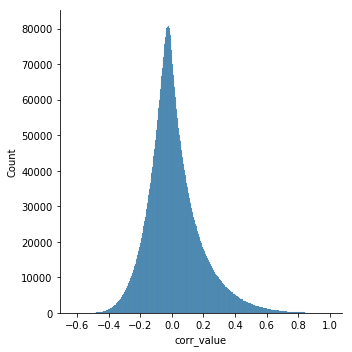

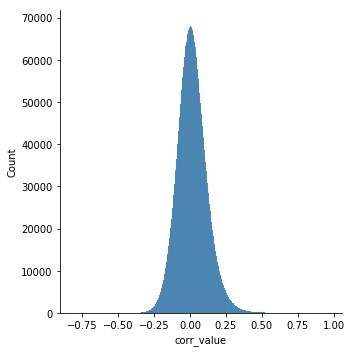

In [9]:
sns.displot(flat_corr_counts_test["corr_value"])
sns.displot(flat_corr_spell_test["corr_value"])

We will create adjacency matrix using threshold defined above.
The adjacency matrix will determine the strength of the connection between two genes.
If the concordance is strong enough (i.e. above the threshold), then the genes are connected by an edge.

Since we're examining the connectedness of genes within a regulon we will **not** take the absolute value of the correlation scores. Regulons are groups of operons that share the same transcription factor and therefore we'd expect genes within the same operon to be positively correlated. Operons are a groups of contiguous genes with a shared promoter sequence. For more information the difference between regulon vs operon read [here](https://pediaa.com/what-is-the-difference-between-operon-and-regulon/)

In [10]:
pao1_counts_adj = (pao1_corr_counts > pao1_corr_counts_threshold).astype(float)
pao1_spell_adj = (pao1_corr_spell > pao1_corr_spell_threshold).astype(float)

In [11]:
pao1_counts_adj.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
PA0002,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
PA0003,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
PA0004,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
PA0005,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
pao1_spell_adj.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA0002,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA0003,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA0004,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA0005,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Evaluate relationships captured

For this experiment, given a set of known gene regulons, that we expect to be clustered together, let's we evaluate which correlation matrix captures these geneset relationships better.
To determine this we calculate the percentage of within (i.e. edges connecting two genes within the geneset) compared to the percentage of edges between (i.e.edges connecting a gene within the geneset and some other external gene).

In [13]:
# Load regulon data
regulon_df = pd.read_csv(regulon_filename, sep=regulon_delim, header=0, index_col=0)

In [14]:
# Format regulon data
regulon_df["Genes"] = regulon_df["Genes"].str.split(";").apply(list)

In [15]:
print(regulon_df.shape)
regulon_df.head()

(31, 2)


,Lengths,Genes
Regulon,,
Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434..."
PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016..."
PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241..."
PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422..."
AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013..."


In [16]:
def compare_within_btwn_edge(adj_df, regulon_df):
    """
    For each input regulon/geneset, this function calculates the
    percentage of edges within genes in the regulon vs the
    percentage of edges between genes in the regulon and some other
    gene.

    This function returns a dataframe containing the percentages for
    each regulon
    """

    # Loop through each regulon
    rows = []
    for regulon_name in regulon_df.index:
        geneset = regulon_df.loc[regulon_name, "Genes"]

        # Processing
        # Since there are some gene ids that are from PA14
        # We will take the intersection
        geneset_processed = set(geneset).intersection(adj_df.index)

        # WITHIN gene calculations
        # Get within edges
        # Since this is a symmetric matrix we only will consider the
        # bottom triangle (excluding the diagonal) in order to count
        # the number of unique connections
        within_df = adj_df.loc[geneset_processed, geneset_processed]
        tril_within_df = within_df.where(
            ~np.triu(np.ones(within_df.shape)).astype(np.bool)
        )

        flat_within_df = tril_within_df.stack().reset_index()
        flat_within_df.columns = ["gene_1", "gene_2", "edge"]
        total_within_pairs = flat_within_df.shape[0]

        # Get proportion of within edges
        num_within_edges = flat_within_df["edge"].sum()
        prop_within = num_within_edges / total_within_pairs

        # BETWEEN calculations
        # Get between edges
        # This matrix is a rectangle of genes in the regulon x genes not in the regulon
        # so we can look at connectsion across the entire matrix as opposed to taking
        # the lower triangle
        not_geneset = set(adj_df.index).difference(geneset_processed)
        between_df = adj_df.loc[geneset_processed, not_geneset]

        flat_between_df = between_df.stack().reset_index()
        flat_between_df.columns = ["gene_1", "gene_2", "edge"]
        total_between_pairs = flat_between_df.shape[0]

        # count the number of within edges
        num_between_edges = flat_between_df["edge"].sum()
        prop_between = num_between_edges / total_between_pairs

        # Make output df
        rows.append(
            {
                "Regulon": regulon_name,
                "Lengths": regulon_df.loc[regulon_name, "Lengths"],
                "Genes": geneset,
                "% within edges": prop_within,
                "% between edges": prop_between,
            }
        )
    output_df = pd.DataFrame(rows)

    return output_df

In [17]:
pao1_counts_stats = compare_within_btwn_edge(pao1_counts_adj, regulon_df)

In [18]:
pao1_spell_stats = compare_within_btwn_edge(pao1_spell_adj, regulon_df)

In [19]:
print(pao1_counts_stats.shape)
pao1_counts_stats

(31, 5)


,Regulon,Lengths,Genes,% within edges,% between edges
0,Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",0.113067,0.003749
1,PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",0.024135,0.007919
2,PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",0.989011,0.010092
3,PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",0.924242,0.009653
4,AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",0.033967,0.008129
5,LasR_regulon,183,"[PA0007, PA0026, PA0027, PA0028, PA0050, PA005...",0.040638,0.004820
6,RhlR_regulon,123,"[PA0059, PA0109, PA0132, PA0144, PA0175, PA017...",0.066658,0.007349
7,PqsR_regulon,133,"[PA0122, PA0355, PA0567, PA0996, PA0997, PA099...",0.024806,0.004579
8,QscR_regulon,405,"[PA0007, PA0059, PA0105, PA0106, PA0107, PA012...",0.025009,0.005113
9,VreI_regulon,30,"[PA0149, PA0532, PA0674, PA0675, PA0676, PA067...",0.324138,0.011549


In [20]:
print(pao1_spell_stats.shape)
pao1_spell_stats.head()

(31, 5)


,Regulon,Lengths,Genes,% within edges,% between edges
0,Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",0.249609,0.005770
1,PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",0.040094,0.008227
2,PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",0.978022,0.005599
3,PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",0.954545,0.001441
4,AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",0.065654,0.008743


In [21]:
# Save dataframes with threshold info
pao1_counts_stats.to_csv(f"pao1_counts_network_top_{top_percent}.tsv", sep="\t")
pao1_spell_stats.to_csv(f"pao1_spell_network_top_{top_percent}.tsv", sep="\t")

In [22]:
# Format data for plotting
pao1_counts_stats_melt = pd.melt(
    pao1_counts_stats.reset_index(),
    id_vars=["Regulon", "Lengths", "Genes"],
    value_vars=["% within edges", "% between edges"],
)

pao1_spell_stats_melt = pd.melt(
    pao1_spell_stats.reset_index(),
    id_vars=["Regulon", "Lengths", "Genes"],
    value_vars=["% within edges", "% between edges"],
)

In [23]:
print(pao1_counts_stats_melt.shape)
pao1_counts_stats_melt

(62, 5)


,Regulon,Lengths,Genes,variable,value
0,Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",% within edges,0.113067
1,PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",% within edges,0.024135
2,PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",% within edges,0.989011
3,PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",% within edges,0.924242
4,AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",% within edges,0.033967
...,...,...,...,...,...
57,LexA_regulon,15,"[PA3008, PA3007, PA3413, PA4763, PA2288, PA341...",% between edges,0.006068
58,GS_genes,3,"[PA0482, PA1376, PA2634]",% between edges,0.003118
59,ErdR_regulon,16,"[PA3604, PA1992, PA1976, PA1978, PA1979, PA198...",% between edges,0.003763
60,SoxR_regulon,6,"[PA2274, PA3718, PA4206, PA4307, PA4208]",% between edges,0.003922


In [24]:
print(pao1_spell_stats_melt.shape)
pao1_spell_stats_melt

(62, 5)


,Regulon,Lengths,Genes,variable,value
0,Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",% within edges,0.249609
1,PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",% within edges,0.040094
2,PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",% within edges,0.978022
3,PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",% within edges,0.954545
4,AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",% within edges,0.065654
...,...,...,...,...,...
57,LexA_regulon,15,"[PA3008, PA3007, PA3413, PA4763, PA2288, PA341...",% between edges,0.007234
58,GS_genes,3,"[PA0482, PA1376, PA2634]",% between edges,0.011930
59,ErdR_regulon,16,"[PA3604, PA1992, PA1976, PA1978, PA1979, PA198...",% between edges,0.005927
60,SoxR_regulon,6,"[PA2274, PA3718, PA4206, PA4307, PA4208]",% between edges,0.004822


Text(0.5, 0.98, '% within vs between edges (using top 1.0%) per regulon')

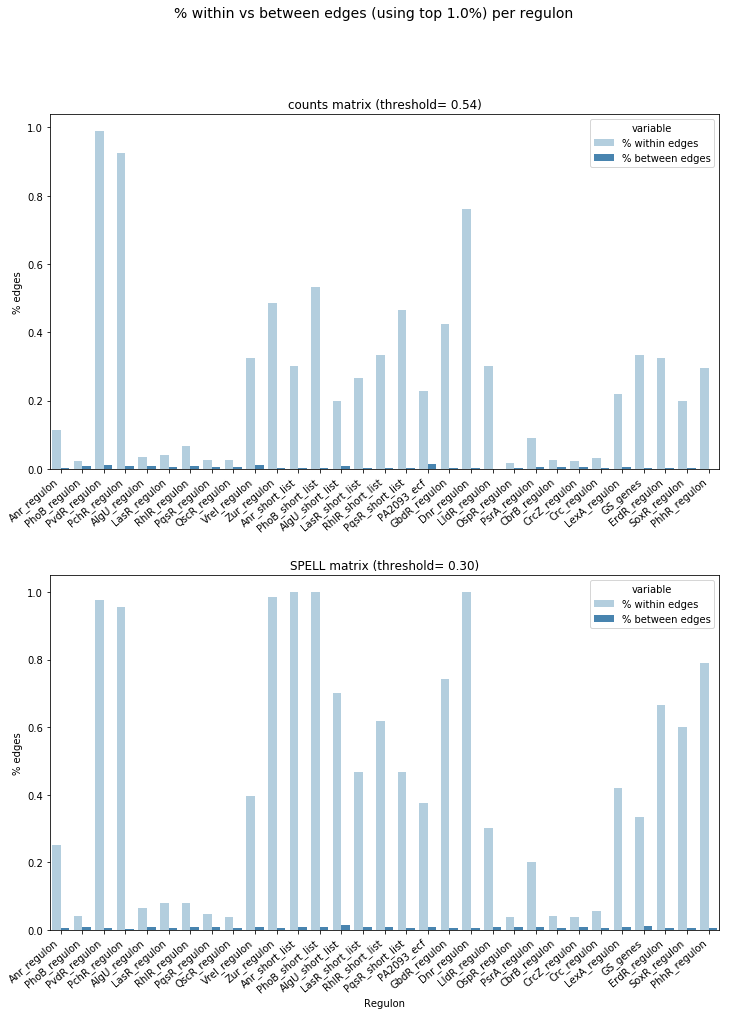

In [25]:
# Make breakdown plot per regulon to see how each contributes
fig1, axes1 = plt.subplots(ncols=1, nrows=2, figsize=(12, 15))

fig1 = sns.barplot(
    data=pao1_counts_stats_melt,
    x="Regulon",
    y="value",
    hue="variable",
    palette="Blues",
    ax=axes1[0],
)
fig1 = sns.barplot(
    data=pao1_spell_stats_melt,
    x="Regulon",
    y="value",
    hue="variable",
    palette="Blues",
    ax=axes1[1],
)
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3
)
axes1[0].set_xticklabels(axes1[0].get_xticklabels(), rotation=40, ha="right")
axes1[1].set_xticklabels(axes1[1].get_xticklabels(), rotation=40, ha="right")
axes1[0].set_title(f"counts matrix (threshold={pao1_corr_counts_threshold: .2f})")
axes1[1].set_title(f"SPELL matrix (threshold={pao1_corr_spell_threshold: .2f})")
axes1[0].set_ylabel("% edges")
axes1[1].set_ylabel("% edges")
axes1[0].set_xlabel("")
axes1[1].set_xlabel("Regulon")
plt.suptitle(
    f"% within vs between edges (using top {top_percent*100}%) per regulon", fontsize=14
)

Text(0.5, 0.98, '% within vs between edges (using top 1.0%)')

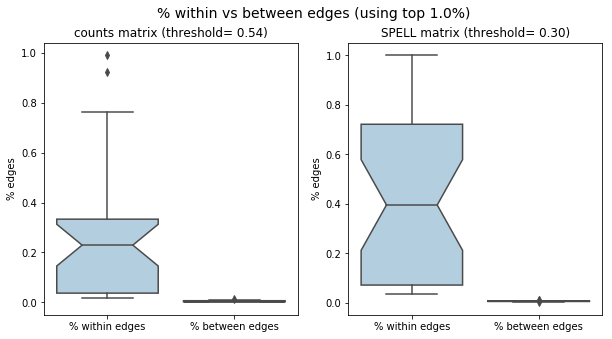

In [26]:
# Make boxplot for number of edges within vs between genes in gene sets/regulons
fig2, axes2 = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

fig2 = sns.boxplot(
    data=pao1_counts_stats_melt,
    x="variable",
    y="value",
    palette="Blues",
    notch=True,
    ax=axes2[0],
)

fig2 = sns.boxplot(
    data=pao1_spell_stats_melt,
    x="variable",
    y="value",
    palette="Blues",
    notch=True,
    ax=axes2[1],
)
axes2[0].set_title(f"counts matrix (threshold={pao1_corr_counts_threshold: .2f})")
axes2[1].set_title(f"SPELL matrix (threshold={pao1_corr_spell_threshold: .2f})")
axes2[0].set_ylabel("% edges")
axes2[1].set_ylabel("% edges")
axes2[0].set_xlabel("")
axes2[1].set_xlabel("")
plt.suptitle(f"% within vs between edges (using top {top_percent*100}%)", fontsize=14)

In [27]:
# Look at the regulons that differed the most to make sure there isn't some sort of bias -
# like they all have very few genes
# Doesn't look to be the case
regulon_df.loc[
    [
        "Zur_regulon",
        "Anr_short_list",
        "PhoB_short_list",
        "AlgU_short_list",
        "LasR_short_list",
        "RhlR_short_list",
        "GbdR_regulon",
        "ErdR_regulon",
        "SoxR_regulon",
        "PhhR_regulon",
    ]
]

,Lengths,Genes
Regulon,,
Zur_regulon,17,"[PA5499, PA5500, PA5501, PA0781, PA3601, PA360..."
Anr_short_list,5,"[PA1673, PA1557, PA5427, PA1555, PA1556]"
PhoB_short_list,6,"[PA3296, PA5360, PA5366, PA5367, PA5368, PA5365]"
AlgU_short_list,5,"[PA0762, PA0763, PA3819, PA5261, PA3385]"
LasR_short_list,6,"[PA3724, PA1871, PA1432, PA2195, PA2194, PA2193]"
RhlR_short_list,7,"[PA3478, PA3477, PA3476, PA3479, PA3333, PA332..."
GbdR_regulon,25,"[PA0843, PA0844, PA2761, PA2762, PA3236, PA529..."
ErdR_regulon,16,"[PA3604, PA1992, PA1976, PA1978, PA1979, PA198..."
SoxR_regulon,6,"[PA2274, PA3718, PA4206, PA4307, PA4208]"


In [28]:
# Save plot
fig1.figure.savefig(
    f"pao1_within_vs_between_edges_top_{top_percent}_per_regulon.svg", dpi=300
)
fig2.figure.savefig(f"pao1_within_vs_between_edges_top_{top_percent}.svg", dpi=300)

### Check

As a control, we will create pseudo-regulons by creating regulons with a random set of size matched genes and comparing the within versus between connections.

The way we calculate the proportions of within and between connections is to take the number of within connections divided by the number of all possible within pairs.
Similarly for the between connections we take the number of between connections divided by the number of all possible between pairs. For this calculation, the denominators are separate because the number of non-regulon genes is much larger.
Our _hypothesis_ is that the between connections are mostly due to noise and randomness in the data. If we divided the number of within connections by the total number of all pairs (within pairs + between pairs) then any signal from the within connections will get drowned out by the noise from the between connections because the size of the regulons are so much smaller.

If the between connections are mostly noise, then we'd expect using a shuffled set of regulons, our within and between connections to be roughly equal in distribution. This is what we find.

In [29]:
# Make shuffled regulon dataset
def make_shuffled_regulon(regulon_df, gene_ids):
    """
    This function inputs real regulon data and creates
    a fake regulon dataset by randomly sampling groups of
    size matched regulons
    """
    rows = []
    for regulon_name in regulon_df.index:
        len_regulon = regulon_df.loc[regulon_name, "Lengths"]

        # Select random set of size-matched genes
        random_geneset = random.sample(gene_ids, len_regulon)

        # Make output df
        rows.append(
            {
                "Regulon": regulon_name,
                "Lengths": regulon_df.loc[regulon_name, "Lengths"],
                "Genes": random_geneset,
            }
        )
    output_df = pd.DataFrame(rows)

    return output_df

In [30]:
shuffled_regulon_df = make_shuffled_regulon(regulon_df, list(pao1_corr_counts.index))

In [31]:
shuffled_regulon_df.head()

,Regulon,Lengths,Genes
0,Anr_regulon,72,"[PA5476, PA2059, PA2159, PA4878, PA2518, PA004..."
1,PhoB_regulon,160,"[PA3426, PA3643, PA0579, PA0135, PA2870, PA165..."
2,PvdR_regulon,14,"[PA4441, PA5436, PA0110, PA2715, PA5048, PA389..."
3,PchR_regulon,12,"[PA2519, PA4753, PA0019, PA1347, PA2959, PA145..."
4,AlgU_regulon,238,"[PA1428, PA1001, PA0785, PA3836, PA3779, PA420..."


In [32]:
pao1_counts_shuffled_stats = compare_within_btwn_edge(
    pao1_counts_adj, shuffled_regulon_df
)

In [33]:
pao1_spell_shuffled_stats = compare_within_btwn_edge(
    pao1_spell_adj, shuffled_regulon_df
)

In [34]:
pao1_counts_shuffled_stats.head()

,Regulon,Lengths,Genes,% within edges,% between edges
0,0,72,"[PA5476, PA2059, PA2159, PA4878, PA2518, PA004...",0.012911,0.012144
1,1,160,"[PA3426, PA3643, PA0579, PA0135, PA2870, PA165...",0.013758,0.011117
2,2,14,"[PA4441, PA5436, PA0110, PA2715, PA5048, PA389...",0.000000,0.008869
3,3,12,"[PA2519, PA4753, PA0019, PA1347, PA2959, PA145...",0.060606,0.016904
4,4,238,"[PA1428, PA1001, PA0785, PA3836, PA3779, PA420...",0.010637,0.010393


In [35]:
# Format data for plotting
pao1_counts_shuffled_stats_melt = pd.melt(
    pao1_counts_shuffled_stats.reset_index(),
    id_vars=["Regulon", "Lengths", "Genes"],
    value_vars=["% within edges", "% between edges"],
)

pao1_spell_shuffled_stats_melt = pd.melt(
    pao1_spell_shuffled_stats.reset_index(),
    id_vars=["Regulon", "Lengths", "Genes"],
    value_vars=["% within edges", "% between edges"],
)

In [36]:
pao1_counts_shuffled_stats_melt.head()

,Regulon,Lengths,Genes,variable,value
0,0,72,"[PA5476, PA2059, PA2159, PA4878, PA2518, PA004...",% within edges,0.012911
1,1,160,"[PA3426, PA3643, PA0579, PA0135, PA2870, PA165...",% within edges,0.013758
2,2,14,"[PA4441, PA5436, PA0110, PA2715, PA5048, PA389...",% within edges,0.000000
3,3,12,"[PA2519, PA4753, PA0019, PA1347, PA2959, PA145...",% within edges,0.060606
4,4,238,"[PA1428, PA1001, PA0785, PA3836, PA3779, PA420...",% within edges,0.010637


Text(0.5, 0.98, '% SHUFFLED within vs between edges (using top 1.0%)')

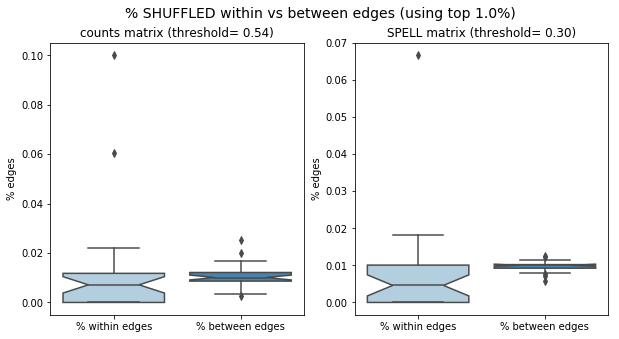

In [37]:
# Make boxplot for number of edges within vs between genes in gene sets/regulons
fig3, axes3 = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

fig3 = sns.boxplot(
    data=pao1_counts_shuffled_stats_melt,
    x="variable",
    y="value",
    palette="Blues",
    notch=True,
    ax=axes3[0],
)

fig3 = sns.boxplot(
    data=pao1_spell_shuffled_stats_melt,
    x="variable",
    y="value",
    palette="Blues",
    notch=True,
    ax=axes3[1],
)
axes3[0].set_title(f"counts matrix (threshold={pao1_corr_counts_threshold: .2f})")
axes3[1].set_title(f"SPELL matrix (threshold={pao1_corr_spell_threshold: .2f})")
axes3[0].set_ylabel("% edges")
axes3[1].set_ylabel("% edges")
axes3[0].set_xlabel("")
axes3[1].set_xlabel("")
plt.suptitle(
    f"% SHUFFLED within vs between edges (using top {top_percent*100}%)", fontsize=14
)